In [176]:
import numpy as np 
import pandas as pd 

from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

import cv2
import numpy as np
from glob import glob
from matplotlib import pylab as plt

import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from skimage.io import imread, imshow
from skimage.transform import resize
import cv2
from tensorflow.keras.layers import (Input, Lambda, Conv2D, Dropout, MaxPooling2D, 
                                     Conv2DTranspose, concatenate, Flatten)



In [177]:
datadir = "/kaggle/input/breast-cancer-cell-data/BreastCancerCell_dataset"
dir1 = os.path.join(datadir)
img_size = (256,256)
num_classes = 2
batch_size = 16

In [178]:
def createDataset(Images, Masks):
    Images = filter(lambda img: img.endswith(".tif"), Images)
    Masks = filter(lambda img: img.endswith(".TIF"), Masks)

    Images = map(lambda img: os.path.join(dir1, img), Images)
    Masks = map(lambda imag: os.path.join(dir1, imag), Masks)

    Images = sorted(Images)
    Masks = sorted(Masks)
    
    return Images, Masks

In [179]:
dataset = createDataset(os.listdir(dir1), os.listdir(dir1))

In [180]:
dataset = pd.DataFrame(dataset).T

In [181]:
class CancerDataset(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            image = imread(path)

            image = cv2.resize(image, img_size)
            image = image/255.0
            x[j] = image
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            image = imread(path)
            
            image = cv2.resize(image, img_size)
    
            image = np.expand_dims(image, axis = -1)
            image = image/255.0
            y[j] = image
        return x, y

In [182]:
imageList = list(dataset[0])
maskList = list(dataset[1])
len(imageList)

58

In [183]:
import random
val_samples = 6 
random.Random(1822).shuffle(imageList)
random.Random(1822).shuffle(maskList)
print(imageList[0])
print(maskList[0])
train_input_img_paths = imageList[:-val_samples]
train_target_img_paths = maskList[:-val_samples]
print(train_input_img_paths[0], train_target_img_paths[0])
val_input_img_paths = imageList[-val_samples:]
val_target_img_paths = maskList[-val_samples:]

# Instantiate data Sequences for each split
train_gen = CancerDataset(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = CancerDataset(6, img_size, val_input_img_paths, val_target_img_paths)

/kaggle/input/breast-cancer-cell-data/BreastCancerCell_dataset/ytma12_010804_malignant3_ccd.tif
/kaggle/input/breast-cancer-cell-data/BreastCancerCell_dataset/ytma12_010804_malignant3.TIF
/kaggle/input/breast-cancer-cell-data/BreastCancerCell_dataset/ytma12_010804_malignant3_ccd.tif /kaggle/input/breast-cancer-cell-data/BreastCancerCell_dataset/ytma12_010804_malignant3.TIF


In [185]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Reshape, Multiply,BatchNormalization,Add,Activation
from tensorflow.keras import Model

def attention_block(F_g, F_l, F_int, bn=False):
    g = Conv2D(F_int, kernel_size=(1, 1), strides=(1, 1), padding='valid')(F_g)
    if bn:
        g = BatchNormalization()(g)
    x = Conv2D(F_int, kernel_size=(1, 1), strides=(1, 1), padding='valid')(F_l)
    if bn:
        x = BatchNormalization()(x)
    psi = Add()([g, x])
    psi = Activation('relu')(psi)
    psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(psi)
    if bn:
        psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi)
    return Multiply()([F_l, psi])

def get_model_with_attention(weights=None, flatten=False, last_activation="sigmoid"):
    inputs = Input((256, 256, 3))
    
    
    c2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(inputs)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(filters=32, kernel_size=(3,3),  activation='relu', kernel_initializer='he_normal',padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2,2))(c2)
    
    c3 = Conv2D(filters=64, kernel_size=(3,3),  activation='relu', kernel_initializer='he_normal',padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(filters=64, kernel_size=(3,3),  activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2,2))(c3)
    
    c4 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(filters=128, kernel_size=(3,3),  activation='relu', kernel_initializer='he_normal',padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)
   
    c5 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c5)
    
    
    u6 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = attention_block(u6, c4, 128, bn=True)
    c6 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    
    u7 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = attention_block(u7, c3, 64, bn=True)
    c7 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

   
    u8 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = attention_block(u8, c2, 32, bn=True)
    c8 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)



    # Outputs
    outputs = Conv2D(filters=1, kernel_size=(1, 1), activation=last_activation)(c8)

    if flatten:
        outputs = Flatten()(outputs)

    model = Model(inputs=[inputs], outputs=[outputs])

    if weights is not None:
        model.load_weights(weights)
    return model

model = get_model_with_attention()

# model_with_attention.summary()


In [186]:
from keras import backend as K

def dice_coef_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coefficient = (2.0 * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    dice_loss = 1.0 - dice_coefficient
    return dice_loss


In [189]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    verbose=1
)

callbacks = [
    keras.callbacks.ModelCheckpoint("cancerSegmentation.h5", save_best_only=True)
]

callbacks_list = [early_stopping, callbacks]



In [197]:
model.compile(optimizer=Adam(learning_rate = 1e-3), loss=dice_coef_loss, metrics=['accuracy'])

In [198]:
epoch = 300
modelunet = model.fit(train_gen,epochs = epoch, validation_data = val_gen,callbacks = callbacks_list)

Epoch 1/300


2023-12-23 12:28:12.728160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_44/dropout_390/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3/3 [==============================] - 15s 843ms/step - loss: 0.4843 - accuracy: 0.9819 - val_loss: 1.0000 - val_accuracy: 0.9815
Epoch 2/300
3/3 [==============================] - 2s 520ms/step - loss: 0.4627 - accuracy: 0.9860 - val_loss: 1.0000 - val_accuracy: 0.9815
Epoch 3/300
3/3 [==============================] - 2s 517ms/step - loss: 0.4442 - accuracy: 0.9842 - val_loss: 0.9999 - val_accuracy: 0.9815
Epoch 4/300
3/3 [==============================] - 2s 522ms/step - loss: 0.4353 - accuracy: 0.9852 - val_loss: 1.0000 - val_accuracy: 0.9815
Epoch 5/300
3/3 [==============================] - 2s 527ms/step - loss: 0.4112 - accuracy: 0.9871 - val_loss: 1.0000 - val_accuracy: 0.9815
Epoch 6/300
3/3 [==============================] - 2s 524ms/step - loss: 0.4025 - accuracy: 0.9866 - val_loss: 1.0000 - val_accuracy: 0.9815
Epoch 7/300
3/3 [==============================] - 2s 525ms/step - loss: 0.3871 - accuracy: 0.9866 - val_loss: 1.0000 - val_accuracy: 0.9815
Epoch 8/300
3/3 [=======

In [208]:
# model = get_model_with_attention()
# optimizer = keras.optimizers.Adam(learning_rate=0.1e-4)
# model.compile(optimizer='adam', loss=dice_coef_loss, metrics=dice_coef)

# epoch = 300
# modelunet = model.fit(train_gen,epochs = epoch, validation_data = val_gen,callbacks = callbacks_list)

In [ ]:
# from tensorflow.keras.optimizers import Adam

# optimizer = keras.optimizers.SGD(learning_rate=0.1)
# model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])

# callbacks = [
#     keras.callbacks.ModelCheckpoint("cancerSegmentation.h5", save_best_only=True)
# ]

# epochs = 300
# modelunet=model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
# model.save_weights("unet")

In [199]:
model.save_weights("unet")

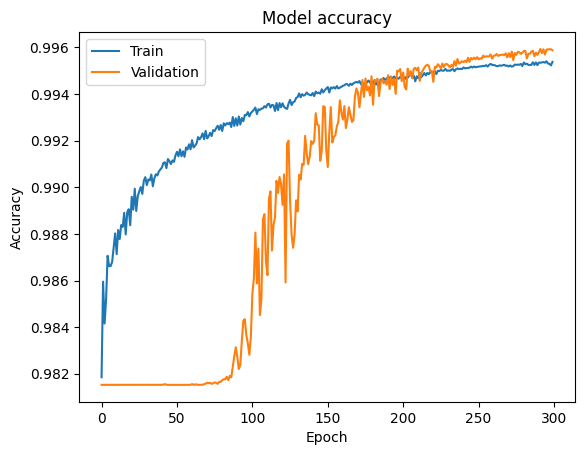

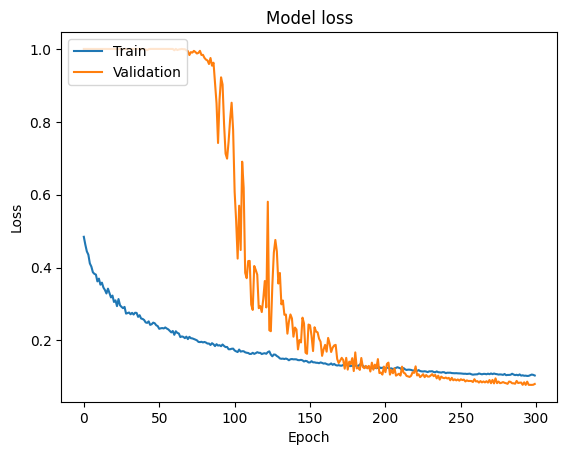

In [201]:
import matplotlib.pyplot as plt

plt.plot(modelunet.history['accuracy'])
plt.plot(modelunet.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(modelunet.history['loss'])
plt.plot(modelunet.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [210]:
training_accuracy = modelunet.history['accuracy']
validation_accuracy = modelunet.history['val_accuracy']

# Print the final accuracy values (last epoch)
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print(f'Final Training Accuracy: {final_training_accuracy * 100:.2f}%')
print(f'Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%')

Final Training Accuracy: 99.54%
Final Validation Accuracy: 99.59%


In [202]:
val_image = imageList[:6]
val_mask = maskList[:6]
val_gen = CancerDataset(6, img_size, val_image, val_mask)
val_preds = model.predict(val_gen)

1/1 [==============================] - 1s 580ms/step


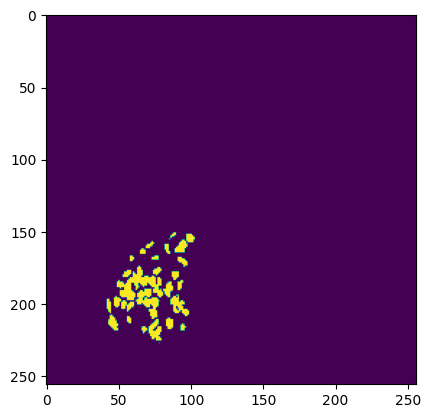

In [203]:
plt.imshow(val_preds[3])

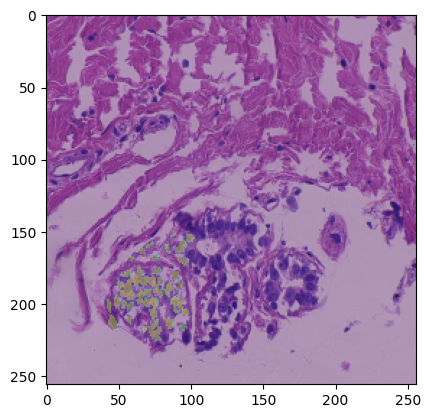

In [204]:
plt.imshow(val_gen.__getitem__(0)[0][3])
plt.imshow(val_preds[3], cmap="viridis", alpha=0.4)

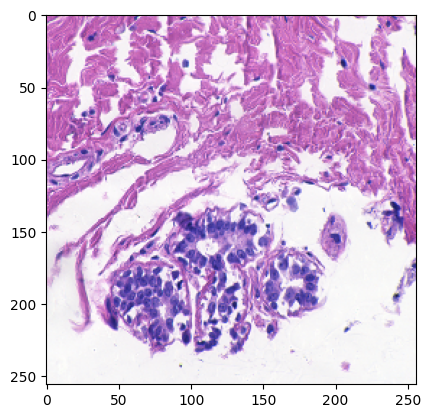

In [205]:
plt.imshow(val_gen.__getitem__(0)[0][3])

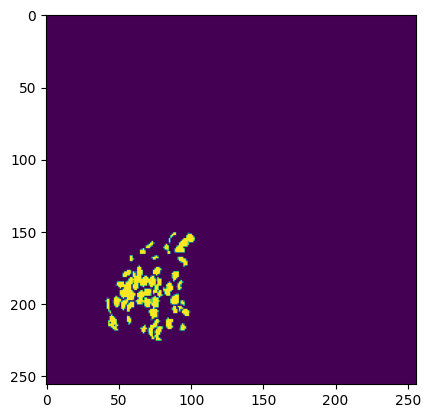

In [206]:
plt.imshow(val_gen.__getitem__(0)[1][3])

1/1 [==============================] - 1s 1s/step


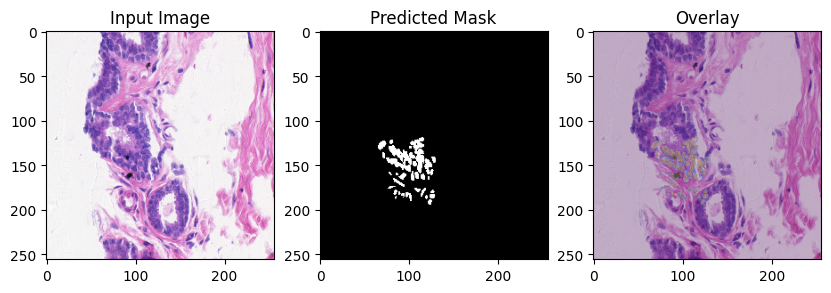

In [207]:

model = get_model_with_attention(weights="unet")


image_path = "/kaggle/input/breast-cancer-cell-data/BreastCancerCell_dataset/ytma10_010704_benign3_ccd.tif"


input_img = imread(image_path)


input_img = cv2.resize(input_img, img_size)
input_img = input_img / 255.0
input_img = np.expand_dims(input_img, axis=0) 


predicted_mask = model.predict(input_img)[0, :, :, 0]


plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_img[0])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")

plt.subplot(1, 3, 3)
plt.imshow(input_img[0])
plt.imshow(predicted_mask, cmap="viridis", alpha=0.3)
plt.title("Overlay")

plt.show()


1/1 [==============================] - 0s 380ms/step


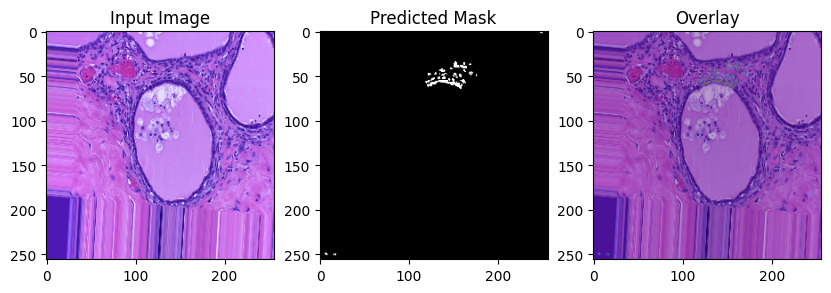

In [215]:

model = get_model_with_attention(weights="unet")


image_path = "/kaggle/input/test12/aug_0_30.jpeg"


input_img = imread(image_path)


input_img = cv2.resize(input_img, img_size)
input_img = input_img / 255.0
input_img = np.expand_dims(input_img, axis=0)  


predicted_mask = model.predict(input_img)[0, :, :, 0]


plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_img[0])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")

plt.subplot(1, 3, 3)
plt.imshow(input_img[0])
plt.imshow(predicted_mask, cmap="viridis", alpha=0.3)
plt.title("Overlay")

plt.show()
